## 读取数据

读入酒店评论数据,统计正面评价和负面评价,共计9999条评论数据。**数据均在ChnSentiCorp_htl_unba_10000文件夹下。**

In [41]:

import numpy as np
import os
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import jieba

from sklearn.datasets import fetch_20newsgroups#引入新闻数据包
from sklearn.feature_extraction.text import TfidfVectorizer#做tfidf编码
from sklearn.feature_selection import SelectKBest, chi2#卡方检验——特征筛选
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC,SVC
from sklearn.naive_bayes import MultinomialNB, BernoulliNB #引入多项式和伯努利的贝叶斯
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
# # SMOTE上采样
from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn import metrics 
plt.rcParams['font.sans-serif'] = ['SimHei']  

# # 数据路径
os.chdir('D:\codePractice\data\\ChnSentiCorp_htl_unba_10000\\')

# 读取正面评论
positive = pd.read_csv('./pos.csv')
# 增加极性标签 
positive['pos_neg']=1
# 正面评论数据统计
pos_len = len(positive)
print("积极评论",pos_len,"条")
# positive.head()
# positive.info()

negative = pd.read_csv('./neg.csv')
# 增加极性标签 
negative['pos_neg']=-1
# 负面评论
neg_len = len(negative)
print("消极评论",neg_len,"条")
# negative.head()
# negative.info()

# 合并评论
comments = pd.concat([positive,negative])

print(comments.info())
# 9899条
comments.head()

积极评论 6900 条
消极评论 2999 条
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9899 entries, 0 to 2998
Data columns (total 2 columns):
comment    9899 non-null object
pos_neg    9899 non-null int64
dtypes: int64(1), object(1)
memory usage: 232.0+ KB
None


,comment,pos_neg
0,"距离川沙公路较近,但是公交指示不对,如果是""蔡陆线""的话,会非常麻烦.建议用别的路线.房间较...",1
1,商务大床房，房间很大，床有2M宽，整体感觉经济实惠不错!,1
2,早餐太差，无论去多少人，那边也不加食品的。酒店应该重视一下这个问题了。房间本身很好。,1
3,宾馆在小街道上，不大好找，但还好北京热心同胞很多~宾馆设施跟介绍的差不多，房间很小，确实挺小...,1
4,"CBD中心,周围没什么店铺,说5星有点勉强.不知道为什么卫生间没有电吹风",1


## 数据预处理

### 数据划分

将数据划为特征x和标签y

In [42]:
# # # 样本不均衡
x = pd.DataFrame(comments.comment)
y = comments.pos_neg
# 查看SMOTE之前的数据分布 
print("总评论中的正负样本:",Counter(y))
# Counter({1: 6900, -1: 2999})

# # 定义SMOTE模型，random_state相当于随机数种子的作用
# smo = SMOTE(random_state=42)
# X_smo, y_smo = smo.fit_sample(x, y)

# # 查看SMOTE之后的数据分布 
# print(Counter(y_smo))

# # 数据集划分
# x_train,x_test,y_train,y_test = train_test_split(x,y,
#                                                  test_size=0.2,
#                                                  random_state=0)

# # # 训练集
# x_train[:5]
# print("训练集中的正负样本：",Counter(y_train))

# # # 测试集
# x_test[:5]
# print("测试集中的正负样本：",Counter(y_test))

x.head()

总评论中的正负样本: Counter({1: 6900, -1: 2999})


,comment
0,"距离川沙公路较近,但是公交指示不对,如果是""蔡陆线""的话,会非常麻烦.建议用别的路线.房间较..."
1,商务大床房，房间很大，床有2M宽，整体感觉经济实惠不错!
2,早餐太差，无论去多少人，那边也不加食品的。酒店应该重视一下这个问题了。房间本身很好。
3,宾馆在小街道上，不大好找，但还好北京热心同胞很多~宾馆设施跟介绍的差不多，房间很小，确实挺小...
4,"CBD中心,周围没什么店铺,说5星有点勉强.不知道为什么卫生间没有电吹风"


### 文档转化向量

#### 读取停用词

读取停用词词典，共计1234个停用词。

In [43]:
# 读取停用词词库
def get_stopwords(stop_words_file):
    with open(stop_words_file,'r',encoding='utf-8') as f:
        stopwords = f.read()
    stopwords_list = stopwords.split('\n')
    custom_stopwords_list = [i for i in stopwords_list]
    return custom_stopwords_list


# 中科院停用词
stop_words_file ="./stopWord.txt"
# 读取停用词 
stopwords = get_stopwords(stop_words_file)[1:]
# 统计停用词个数
print("一共含有%d个停用词" % len(stopwords))
# 查看前10个停用词
stopwords[-10:]

一共含有1207个停用词


['如下', '汝', '三番两次', '三番五次', '三天两头', '瑟瑟', '沙沙', '上', '上来', '上去']

#### 分词

结巴分词，并去除英文和数字

In [44]:
import re

# 分词预处理
def clean_text(line):
    if line!=' ':
        line = line.strip()
        # 去除英文和数字
        line = re.sub("[a-zA-Z0-9]","",line)
        # 去除文本中的中文符号和英文符号 
        line = re.sub("[\s+\.\,\!\/_,$%^*(+\"\'；：“”．]+|[+——！，。？?、~@#￥%……&*（）]+", "", line)
        return line
    else:
        return "Empyt Line."
    
# 结巴分词
def chinese_word_cut(line):
    line = clean_text(line)
    segList = jieba.cut(line,cut_all=False)
    segSentence = ''
    for word in segList:
        if word!='\t' and (word not in stopwords):
            segSentence += (word+" ")
    return segSentence.strip()

In [45]:
# 评论分词 
x['cutted_comment'] = x.comment.apply(chinese_word_cut)
print(x.shape)
# (9899, 2)

# # 分词结果
x.cutted_comment[:5]
## BOW TFIDF WORD2VECh获取特征 

(9899, 2)


0               距离 川沙 公路 较近 公交 指示 蔡陆线 麻烦 建议 路线 房间 较为简单
1                    商务 大床 房 房间 很大 床有 宽 整体 感觉 经济 实惠 不错
2                   早餐 太 差 人 不加 食品 酒店 应该 重视 一下 问题 房间 好
3    宾馆 小 街道 不大好 找 还好 北京 热心 同胞 宾馆 设施 介绍 房间 很小 确实 挺 ...
4                     中心 周围 没什么 店铺 说星 有点 勉强 知道 卫生间 电吹风
Name: cutted_comment, dtype: object

#### 文本向量表示

利用词袋模型将文本向量化。
- 利用停用词过滤;
- max_df = 0.9设置为0.9，即一个词语在90%以上的文件中出现则不能作为特征词语;
- min_df=3设置为3，即一个词语最少在3个文件中出现过才能当作特征词语;

In [46]:
from sklearn.feature_extraction.text import CountVectorizer
# 过滤部分特征
# 最大比例
max_df = 0.9
# 最小支持度
min_df = 3
# 加入token
token_pattern = u'(?u)\\b[^\\d\\W]\\w+\\b'

# 构建cbow向量
vectorizer = CountVectorizer(min_df = min_df,
               token_pattern=token_pattern,
               stop_words=frozenset(stopwords))

#### 训练集和测试集划分

按照8:2将数据集划为为训练集和测试集

In [47]:
# 数据集划分
x_train,x_test,y_train,y_test = train_test_split(x,y,
                                                 test_size=0.2,
                                                 random_state=0)

# 训练集和测试集
x_train = x_train['cutted_comment']
x_test = x_test['cutted_comment']

# 文本向量化
train_x = vectorizer.fit_transform(x_train)
test_x = vectorizer.transform(x_test)

# # 训练集
x_train[:5]
print("训练集中的正负样本：",Counter(y_train))
print("训练集样本个数:%d,特征个数:%d" % train_x.shape)

# # 测试集
x_test[:5]
print("测试集中的正负样本：",Counter(y_test))
print("测试集样本个数:%d,特征个数:%d\n" % test_x.shape)

feature_names = np.asarray(vectorizer.get_feature_names())
print("特征筛选前特征个数:{}\n词汇:{}".format(len(feature_names),feature_names))
# # 训练文本
x_train.head()

训练集中的正负样本： Counter({1: 5516, -1: 2403})
训练集样本个数:7919,特征个数:8347
测试集中的正负样本： Counter({1: 1384, -1: 596})
测试集样本个数:1980,特征个数:8347

特征筛选前特征个数:8347
词汇:['一一' '一下' '一下下' ... '龙卡' '龙头' '龙门石窟']


5279                交通 便利 环境 尚可 提供 早餐 比较 好 旧 一点 总体 说 令人满意
2929                                                喜欢 下次
5496    六号楼 龙岩 地区 目前 最好 宾馆 硬件 新 服务 感觉 不错 美中不足 暖气 不行 晚上...
5253    白天 恐龙 园 游玩 过后 月 号 富 商贸 酒店 住 一晚 住 元 高级 双床 房 最 普...
3078                  总体 感觉 比较 好 环境 一点 吵 挨近 一条 高架路 服务态度 好
Name: cutted_comment, dtype: object

## 特征选择

上一步可以看到，通过停用词和min_df、max_df的筛选之后，特征词语有8347个，为了降维，此步通过卡方进行特征选择。卡方进行特征值选择之后保留与y最相关的1000个词。

In [48]:
# # 特征选择
ch2 = SelectKBest(chi2,k=1000)
x_train = ch2.fit_transform(train_x,y_train)
x_test = ch2.transform(test_x)
feature_names = [feature_names[i] for i in 
                 ch2.get_support(indices=True)]

# # 特征词查看
print("特征筛选后特征个数:{}\n\n1000个特征词汇为:\n {}".format(len(feature_names),feature_names))

特征筛选后特征个数:1000

1000个特征词汇为:
 ['一下', '一个', '一会', '一分', '一分货', '一口咬定', '一句', '一只', '一块', '一堆', '一塌糊涂', '一夜', '一天', '一座', '一张', '一无是处', '一早', '一晚', '一次', '一次性', '一流', '一直', '一看', '一碰', '一米', '一股', '一间', '万豪', '三个', '三思', '三星', '三星级', '上当', '上面', '下午', '下咽', '下来', '下楼', '下次', '下水管', '下水道', '不住', '不信', '不值', '不停', '不到', '不去', '不可思议', '不好', '不想', '不敢', '不敢恭维', '不来', '不热', '不爽', '不理', '不知', '不符', '不肯', '不行', '不见', '不象话', '不负责任', '不足', '不远', '不错', '东西', '丢人', '两个', '两张', '两样', '严重', '中午', '中央空调', '中年男人', '丰富', '丰盛', '临时', '为此', '久久', '义务', '之下', '之后', '之差', '之星', '九洲', '乱收费', '争执', '事件', '事先', '事情', '二十分钟', '二星', '交涉', '交警', '交通', '产生', '亲切', '亲戚', '人员', '人理', '今后', '从没', '付钱', '代理', '令人', '令人气愤', '以上', '以为', '以后', '以来', '价格合理', '企业', '休闲', '会员', '会员卡', '传真', '估计', '位置', '低下', '低档', '低级', '住天', '住店', '依然', '便利', '保安', '保证', '信任', '信号', '信用卡', '修好', '修理', '值得', '值班', '偏僻', '做事', '做出', '停电', '催促', '傻子', '先到', '免费', '入主', '入住', '入睡', '全价', '全国', '全是', '全部', '八点', '公园', '公安部门', '六点', '关不上', '关不紧',

## 构建不同的分类器

- 构建多种分类器：线性最小二乘L2正则(RidgeClassiﬁer)、K近邻 (KNeighborsClassiﬁer)、朴素贝叶斯(MultinomialNB)、随机森林(RandomForestClassiﬁer)、SVM(SVC:hinge损失 的绝对值)、线性核SVM(LinearSVC:平方hinge损失+L1正则)、线性核SVM(LinearSVC:平方hinge损失+L2正则)
- 通过网格搜索找到最优参数


In [49]:
# # 基准模型 
def benchmark(clf,name):
    print("分类器:",clf)
    
    # 设置最优参数，5折交叉验证
    alpha_can = np.logspace(-2,1,10)
    model = GridSearchCV(clf,param_grid={'alpha':
                                         alpha_can}, cv=5)
    m = alpha_can.size
    
    # alpha参数
    if hasattr(clf,'alpha'):
        model.set_params(param_grid={'alpha':alpha_can})
        m = alpha_can.size
        
    # k近邻
    if hasattr(clf,'n_neighbors'):
        neighbors_can = np.arange(1,15)
        model.set_params(param_grid={'n_neighbors':
                                     neighbors_can})
        m = neighbors_can.size
        
    # LinearSVC参数
    if hasattr(clf,'C'):
        C_can = np.logspace(1,3,3)
        model.set_params(param_grid={'C':C_can})
        
    # SVM参数
    if hasattr(clf,'C') & hasattr(clf,'gamma'):
        C_can = np.logspace(1,3,3)
        gamma_can = np.logspace(-3,0,3)
        model.set_params(param_grid={'C':C_can,'gamma':gamma_can})
        m = C_can.size*gamma_can.size
    # 深度参数
    if hasattr(clf,'max_depth'):
        max_depth_can = np.arange(4,10)
        model.set_params(param_grid={'max_depth':max_depth_can})
        m = max_depth_can.size
        
    # # 训练模型
    t_start = time()
    model.fit(train_x,y_train)
    t_end = time()
    t_train = (t_end-t_start)/(5*m)
    print("5折交叉验证的训练时间为:%.3f/(5*%d)=%.3f秒"
         %((t_end-t_start),m,t_train))
    print("最优参数为:",model.best_params_)
    
    # # 模型预测 
    t_start = time()
    y_hat = model.predict(test_x)
    t_end = time()
    t_test = t_end -t_start
    print("测试时间：%.3f秒"%t_test)
     
    # # 模型评估 
    # # 训练集
    train_acc = metrics.accuracy_score(y_train,
                                       model.predict(
                                           train_x))
    # # 测试集 
    test_acc = metrics.accuracy_score(y_test,y_hat)
    print("训练集准确率:%.2f%%"%(100*train_acc))
    print("测试集准确率:%.2f%%"%(100*test_acc))
    
    # # 返回结果
    return t_train,t_test,1-train_acc,1-test_acc,name

In [51]:
# # 不同分类器比较
print("分类器的比较:\n")
clfs = [
    [RidgeClassifier(),'Ridge'],# 线性分类器-最小二乘+L2正则
    [KNeighborsClassifier(),'KNN'],# K临近
    [MultinomialNB(),'MultinomialNB'],# 朴素贝叶斯
    [RandomForestClassifier(n_estimators=200),'RandomForest'],# 随机森林
    [SVC(),'SVM'],# svm:采用svc(),损失是hinge损失的绝对值
    [LinearSVC(loss='squared_hinge',penalty='l1', # 线性可分支持向量积,平方Hinge损失+L1正则
               dual=False,tol=1e-4),'LinearSVC-l1'],
    [LinearSVC(loss='squared_hinge',penalty='l2', # 线性可分支持向量积,平方Hinge损失+L2正则
               dual=False,tol=1e-4),'LinearSVC-l2']
]

# # 训练数据保存到列表
result = []
for clf,name in clfs:
    # 计算结果 
    a = benchmark(clf,name)
    result.append(a)
    print('\n')
# # 
result = np.array(result)

分类器的比较:

分类器: RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='auto',
        tol=0.001)
5折交叉验证的训练时间为:41.859/(5*10)=0.837秒
最优参数为: {'alpha': 0.21544346900318834}
测试时间：0.000秒
训练集准确率:88.95%
测试集准确率:86.62%


分类器: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
5折交叉验证的训练时间为:95.239/(5*14)=1.361秒
最优参数为: {'n_neighbors': 1}
测试时间：0.389秒
训练集准确率:99.97%
测试集准确率:80.61%


分类器: MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
5折交叉验证的训练时间为:0.325/(5*10)=0.007秒
最优参数为: {'alpha': 0.21544346900318834}
测试时间：0.000秒
训练集准确率:91.67%
测试集准确率:87.07%


分类器: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_s

## 模型比较

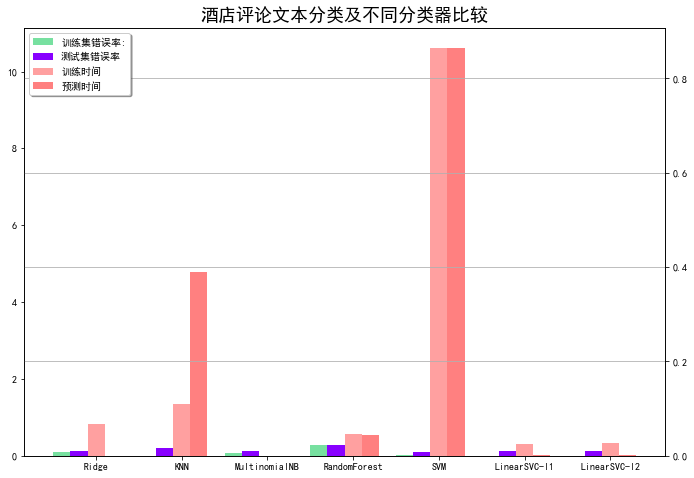

In [52]:
# 数据 
result = [[x[i] for x in result] for i in range(5)]
training_time,test_time,traning_err,test_err,clf_names =  result

training_time = np.array(training_time).astype(np.float)
test_time = np.array(test_time).astype(np.float)
traning_err = np.array(traning_err).astype(np.float)
test_err = np.array(test_err).astype(np.float)

# 可视化
x = np.arange(len(training_time))
plt.figure(figsize=(10,7),facecolor='w')
ax = plt.axes()
b0 = ax.bar(x+0.1,traning_err,width=0.2,color='#77E0A0')
b1 = ax.bar(x+0.3,test_err,width=0.2,color='#8800FF')
ax2 = ax.twinx()
b2 = ax.bar(x+0.5,training_time,width=0.2,color='#FFA0A0')
b3 = ax2.bar(x+0.7,test_time,width=0.2,color='#FF8080')
plt.xticks(x+0.5,clf_names)
plt.legend([b0[0],b1[0],b2[0],b3[0]],("训练集错误率:",
                                   "测试集错误率",
                                  "训练时间",
                                  "预测时间"),
                                  loc = 'upper left',
                                  shadow = True)

plt.title("酒店评论文本分类及不同分类器比较",fontsize=18)
plt.xlabel("分类器名称")
plt.grid(True)
plt.tight_layout(2)
plt.show()

## 结果分析

- 多种分类器中，SVM和KNN依然训练时间高于其他分类，Ridg线性分类器训练时间也相对较长。但是SVM虽然训练时间长，其分类准确率在训练集和测试集都很高，表现良好。KNN在文本分类中效率较为低下，耗时长且错误率高。其余的分类器表现差异不大。

- 但在模型训练过程中，LinearSVC-l1报了收敛警告，LinearSVC-l2没有收敛警告，且表现不错。对比高斯核SVM(利用SVC类),线性核LinearSVC-l1(利用LinearSVC类，hinge损失的绝对值，惩罚项是l1)以及线性核LinearSVC-l2(利用 hinge损失的绝对值，惩罚项是l2)。 高斯核SVM虽然时间消耗大，但是表现良好。由于非线性核函数，该项目中是针对文本情感分类，利用CBOW模型进 行向量化，提取部分特征之后非线性变化。分析认为是文本信息和数值数据本身就不一样，文本数据的模型刻画中已 经进行了很多抽象化的操作，所以非线性变化较为合适。

- LinearSVC类是基于liblinear,罚函数是对截矩进行惩罚，损失函数是基于hing损失的平方，可以用梯度下降优化。 SVC基于libsvm，罚函数不是对截矩进行惩罚，损失函数基于hing损失(非凸)，无法使用梯度下降求解。SVM解决问 题时，问题是分为线性可分和线性不可分问题的，liblinear对线性可分问题做了优化，故在大量数据上收敛速度比 libsvm快。这也合理的解释了上图中时间维度信息。 对于不同的惩罚函数，线性核LinearSVC-l1采用l1作为惩罚项，线性核LinearSVC-l2采用l2作为惩罚项，LinearSVC-l1 有收敛性警告，但LinearSVC-l2没有，分析原因主要是该项目中在向量化之前已经进行了特征筛选，剩余1000个特征 词汇，对于一条评论命中一个词汇概率已经较低。LinearSVC-l1利用l1作为惩罚项，本身就具备特征筛选的作用，对 于很多评论而言，这很可能导致参数为0，所以收敛性无法保证。

通过三者对比，特征选择与否以及数据本身特征对于模型的选择和建立很重要。